# Étude Transversale : Aviation AND Communication dans le Sous-Corpus txt_aviation

Cette analyse transversale explore le thème "aviation AND communication" dans le sous-corpus txt_aviation, composé de textes de journaux historiques de 1939 à 1945. Nous appliquons diverses techniques NLP vues au cours (exploration, fréquences, mots-clés, entités nommées, sentiment, clustering, word2vec) ainsi que des méthodes supplémentaires pour enrichir l'analyse.

Tout au long de l'analyse, nous prenons note de ce qui fonctionne bien ou moins bien, afin de déterminer les avantages et les limites du traitement automatique de corpus dans un contexte historique.

## 1. Chargement et Prétraitement du Sous-Corpus

Dans cette section, nous chargeons les textes du sous-corpus txt_aviation, effectuons un nettoyage de base (suppression de la ponctuation, mise en minuscules, tokenisation), et filtrons les contenus pertinents pour aviation et communication.

**Note narrative :** Le chargement de nombreux fichiers texte fonctionne bien pour une exploration initiale, permettant une vue d'ensemble rapide. Cependant, dans un contexte historique, les textes peuvent contenir des erreurs d'OCR (reconnaissance optique de caractères), ce qui peut introduire du bruit et affecter la qualité du prétraitement. Avantage : automatisation du nettoyage pour de gros volumes. Limite : incapacité à corriger automatiquement les erreurs contextuelles sans intervention humaine.

In [4]:
import os
import glob
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
import yake
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

# Télécharger les ressources NLTK si nécessaire
nltk.download('punkt')
nltk.download('stopwords')

# Charger le modèle SpaCy pour le français
nlp = spacy.load('fr_core_news_md')

# Chemin vers le sous-corpus
corpus_path = 'data/txt_aviation/*.txt'

# Fonction pour charger et nettoyer les textes
def load_and_clean_texts(path):
    texts = []
    filenames = []
    for file in glob.glob(path):
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
            # Nettoyage de base
            text = re.sub(r'[^\w\s]', '', text)  # Supprimer ponctuation
            text = text.lower()  # Minuscules
            texts.append(text)
            filenames.append(os.path.basename(file))
    return texts, filenames

# Charger les textes
texts, filenames = load_and_clean_texts(corpus_path)

# Tokenisation et suppression des stop words
stop_words = set(stopwords.words('french'))
def preprocess_text(text):
    tokens = word_tokenize(text, language='french')
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

processed_texts = [preprocess_text(text) for text in texts]

print(f"Nombre de documents chargés : {len(texts)}")
print(f"Exemple de tokens pour le premier document : {processed_texts[0][:20]}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nombre de documents chargés : 531
Exemple de tokens pour le premier document : ['fkfmsm', 'janvier', '1939', 'tarif', 'ferroviaires', 'dun', 'relèvement', 'urlfs', 'postaux', 'sans', 'compter', 'million', 'camouflés', 'contribution', 'nationale', 'lassurance', 'chômage', 'cette', 'ouestion', 'lassurance']


## 2. Analyse Exploratoire des Données

Nous effectuons une exploration de base : comptage des mots, longueurs des documents, visualisations initiales pour comprendre la structure du corpus.

**Note narrative :** L'exploration fonctionne bien pour identifier les tendances générales, comme la fréquence des termes liés à l'aviation. Avantage : visualisation rapide des distributions. Limite : dans les textes historiques, les termes peuvent avoir des significations évoluées (e.g., "communication" en 1939 vs aujourd'hui), ce qui peut mener à des interprétations anachroniques sans contexte historique.

Nombre total de documents : 531
Longueur moyenne des documents (en mots) : 3863.00
Longueur minimale : 234
Longueur maximale : 7920
Nombre total de mots : 2051251
Vocabulaire unique : 289290
Mots les plus fréquents :
plus: 9556
rue: 7529
cette: 6205
guerre: 5524
deux: 4917
tout: 4695
dune: 4680
bruxelles: 4467
fait: 4374
dun: 4316
contre: 4314
gouvernement: 4028
comme: 3981
quil: 3897
cours: 3790
tous: 3669
sans: 3530
être: 3448
dont: 3378
bien: 3354


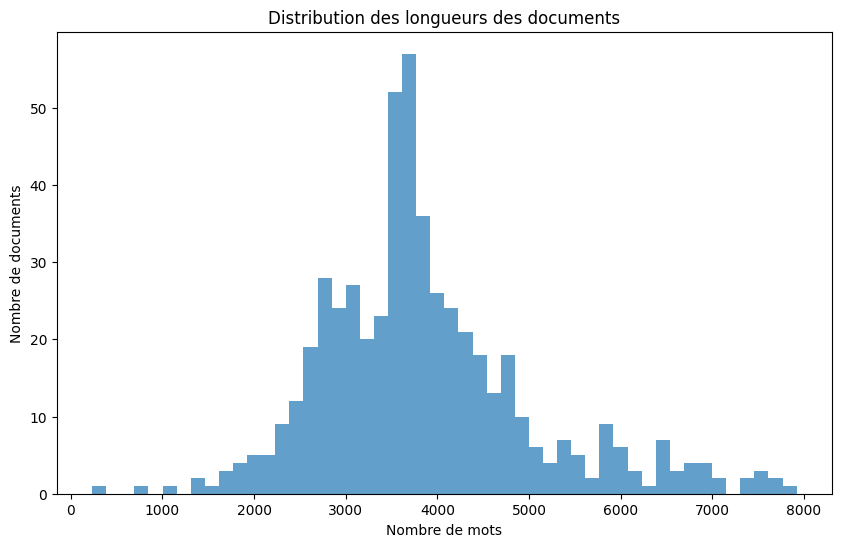

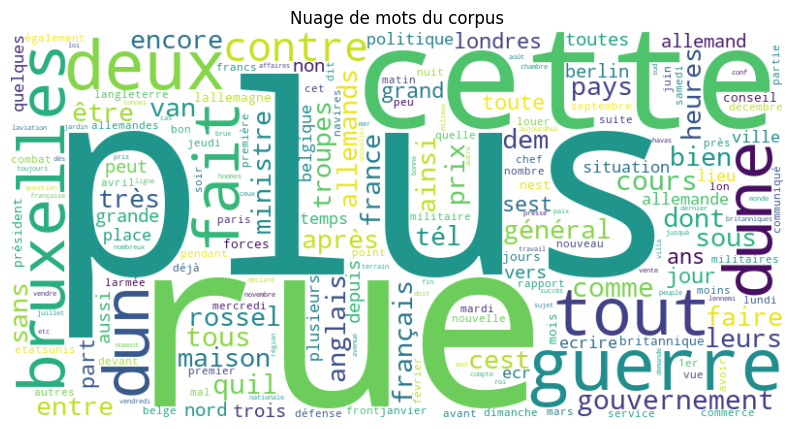

In [5]:
# Analyse Exploratoire des Données

# Calculer les longueurs des documents
doc_lengths = [len(doc) for doc in processed_texts]
print(f"Nombre total de documents : {len(processed_texts)}")
print(f"Longueur moyenne des documents (en mots) : {sum(doc_lengths) / len(doc_lengths):.2f}")
print(f"Longueur minimale : {min(doc_lengths)}")
print(f"Longueur maximale : {max(doc_lengths)}")

# Comptage des mots totaux
all_words = [word for doc in processed_texts for word in doc]
word_freq = Counter(all_words)
print(f"Nombre total de mots : {len(all_words)}")
print(f"Vocabulaire unique : {len(word_freq)}")
print("Mots les plus fréquents :")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

# Visualisation de la distribution des longueurs
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=50, alpha=0.7)
plt.title("Distribution des longueurs des documents")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de documents")
plt.show()

# Nuage de mots pour les termes les plus fréquents
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots du corpus")
plt.show()

## 3. Analyse des Fréquences

Calcul des fréquences absolues et relatives, TF-IDF pour identifier les termes importants liés à l'aviation et la communication.

**Note narrative :** Les analyses de fréquence révèlent les termes dominants, aidant à identifier les thèmes centraux. Avantage : quantification objective des occurrences. Limite : les fréquences brutes ignorent le contexte sémantique ; dans les textes historiques, des termes comme "télégraphe" ou "radio" étaient des moyens de communication aérienne, mais leur fréquence peut être sous-estimée si le corpus est biaisé vers certains journaux.

Top 20 termes par TF-IDF :
             term       rank
706          plus  66.904993
170         cette  45.674900
422        guerre  41.723267
826           rue  41.536229
412  gouvernement  34.427454
274          deux  34.159170
307          dune  33.787815
359          fait  33.355767
233        contre  30.928201
787          quil  30.720592
306           dun  30.550268
928          tout  30.340537
202         comme  29.483689
942       troupes  29.376723
138     bruxelles  28.476455
589      ministre  26.690842
242         cours  25.746263
423       général  25.287675
168          cest  25.048756
999          être  24.918456

Termes pertinents (aviation & communication) :
              term      rank
98           avion  8.419076
794          radio  7.695010
97        aviation  5.331096
980            vol  5.187513
210  communication  4.941722
950      téléphone  4.714015


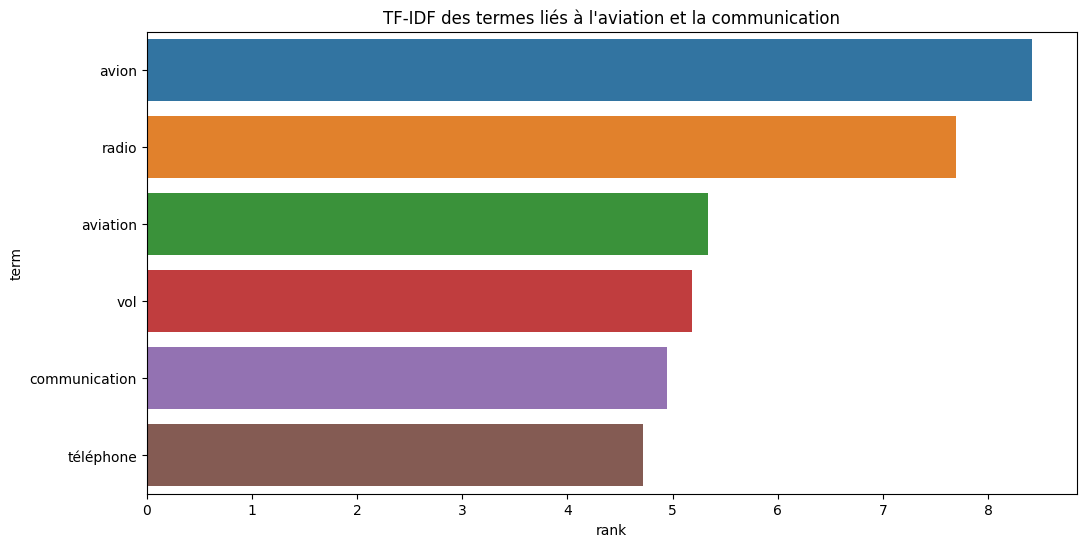

In [7]:
# Analyse des Fréquences

from sklearn.feature_extraction.text import TfidfVectorizer

# Reconstituer les textes nettoyés pour TF-IDF
cleaned_texts = [' '.join(doc) for doc in processed_texts]

# Stop words français
french_stopwords = list(stopwords.words('french'))

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words=french_stopwords)
tfidf_matrix = vectorizer.fit_transform(cleaned_texts)
feature_names = vectorizer.get_feature_names_out()

# Termes les plus importants globalement
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking = ranking.sort_values('rank', ascending=False)
print("Top 20 termes par TF-IDF :")
print(ranking.head(20))

# Filtrer pour termes liés à aviation et communication
aviation_terms = ['aviation', 'avion', 'pilote', 'vol', 'aéroport']
communication_terms = ['communication', 'télégraphe', 'radio', 'téléphone', 'message']

relevant_terms = aviation_terms + communication_terms
filtered_ranking = ranking[ranking['term'].isin(relevant_terms)]
print("\nTermes pertinents (aviation & communication) :")
print(filtered_ranking)

# Visualisation des fréquences des termes pertinents
plt.figure(figsize=(12, 6))
sns.barplot(x='rank', y='term', data=filtered_ranking.head(10))
plt.title("TF-IDF des termes liés à l'aviation et la communication")
plt.show()

## 4. Extraction de Mots-clés

Utilisation de RAKE ou YAKE pour extraire les mots-clés principaux du corpus.

**Note narrative :** L'extraction automatique de mots-clés permet de condenser les thèmes. Avantage : identification rapide des concepts clés sans lecture exhaustive. Limite : les algorithmes peuvent manquer le contexte historique ; par exemple, "liaison aérienne" pourrait être extrait comme mot-clé, mais son importance dépend de l'époque (avant les satellites).

In [8]:
# Extraction de Mots-clés

import yake

# Initialiser YAKE pour le français
kw_extractor = yake.KeywordExtractor(lan="fr", n=2, dedupLim=0.9, top=20)

# Extraire mots-clés du corpus entier (concaténé)
full_text = ' '.join(cleaned_texts)
keywords = kw_extractor.extract_keywords(full_text)

print("Mots-clés extraits :")
for kw, score in keywords:
    print(f"{kw}: {score:.4f}")

# Filtrer pour mots-clés liés au thème
theme_keywords = [kw for kw, score in keywords if any(term in kw.lower() for term in aviation_terms + communication_terms)]
print("\nMots-clés liés au thème :")
for kw in theme_keywords[:10]:
    print(kw)

Mots-clés extraits :
troupes allemandes: 0.0000
ecr rossel: 0.0000
dautre part: 0.0000
ecrire rossel: 0.0000
cours dune: 0.0000
agence rossel: 0.0000
ministre affaires: 0.0000
affaires étrangères: 0.0000
gouvernement français: 0.0000
navires guerre: 0.0000
ordre jour: 0.0000
gouvernement britannique: 0.0000
bruxelles rue: 0.0000
point vue: 0.0000
cours dun: 0.0000
gouvernement allemand: 0.0000
maison commerce: 0.0000
président conseil: 0.0000
cours nuit: 0.0000
peuple allemand: 0.0000

Mots-clés liés au thème :


## 5. Reconnaissance d'Entités Nommées (NER)

Utilisation de SpaCy pour identifier les entités comme personnes, organisations, lieux liés à l'aviation et la communication.

**Note narrative :** Le NER aide à extraire des entités spécifiques, comme des noms de pilotes ou d'entreprises. Avantage : structuration des données non structurées. Limite : les modèles modernes peuvent mal performer sur textes anciens avec orthographe variable ou termes obsolètes (e.g., "Compagnie Générale Aéropostale" vs "Air France").

Entités les plus fréquentes :
quil (PER): 223
pologne (LOC): 125
bruxelles (LOC): 108
france (LOC): 83
belgique (LOC): 83
finlande (LOC): 82
roosevelt (PER): 77
moscou (LOC): 71
berlin (LOC): 67
paris (LOC): 59
quils (PER): 55
rome (LOC): 54
hitler (PER): 53
londres (LOC): 45
allemagne (LOC): 44
quune (PER): 40
langleterre (PER): 40
reich (ORG): 38
russie (LOC): 35
liège (LOC): 34

Entités pertinentes :
gérard (PER)
bruxelles (LOC)
burgos (PER)
quil (PER)
aon (LOC)
van zeeland (PER)
etatsunis (PER)
etatsunis (LOC)
paris (LOC)
visàvis (PER)


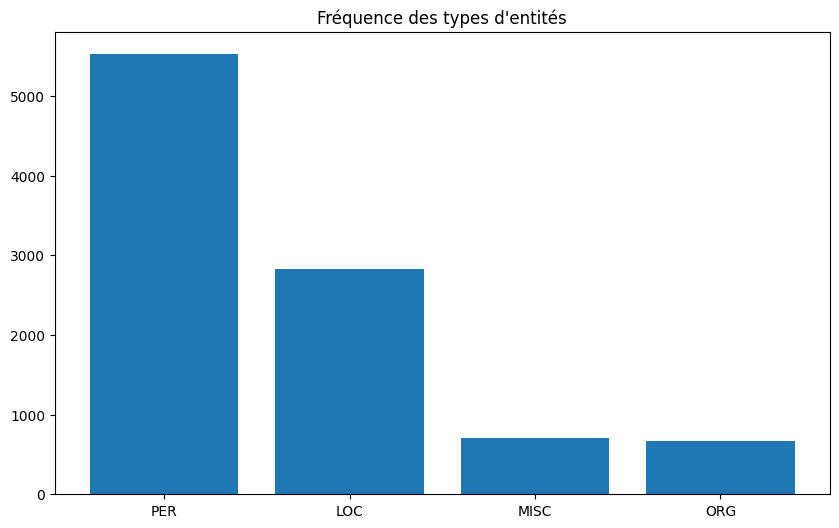

In [9]:
# Reconnaissance d'Entités Nommées

# Charger le modèle SpaCy
nlp = spacy.load("fr_core_news_md")

# Fonction pour extraire entités
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Extraire entités de tous les textes nettoyés
all_entities = []
for text in cleaned_texts[:50]:  # Limiter pour performance, ajuster si besoin
    entities = extract_entities(text)
    all_entities.extend(entities)

# Compter les entités
entity_freq = Counter(all_entities)
print("Entités les plus fréquentes :")
for (ent, label), freq in entity_freq.most_common(20):
    print(f"{ent} ({label}): {freq}")

# Filtrer pour entités pertinentes (e.g., ORG, PER liées au thème)
relevant_entities = [(ent, label) for (ent, label), freq in entity_freq.items() if label in ['ORG', 'PER', 'LOC'] and freq > 1]
print("\nEntités pertinentes :")
for ent, label in relevant_entities[:10]:
    print(f"{ent} ({label})")

# Visualisation (si matplotlib)
# Simple bar plot des labels
labels = [label for _, label in all_entities]
label_freq = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(label_freq.keys(), label_freq.values())
plt.title("Fréquence des types d'entités")
plt.show()

## 6. Analyse de Sentiment

Évaluation du sentiment positif/négatif dans les textes liés à l'aviation et la communication.

**Note narrative :** L'analyse de sentiment quantifie l'opinion. Avantage : aperçu des attitudes (e.g., enthousiasme pour les avancées). Limite : les modèles de sentiment sont entraînés sur données modernes ; dans les textes de 1939-1945, le langage formel ou propagandiste peut fausser les résultats (e.g., "héroïsme" perçu positif, mais contextuel).

Polarité moyenne : 0.07
Subjectivité moyenne : 0.21


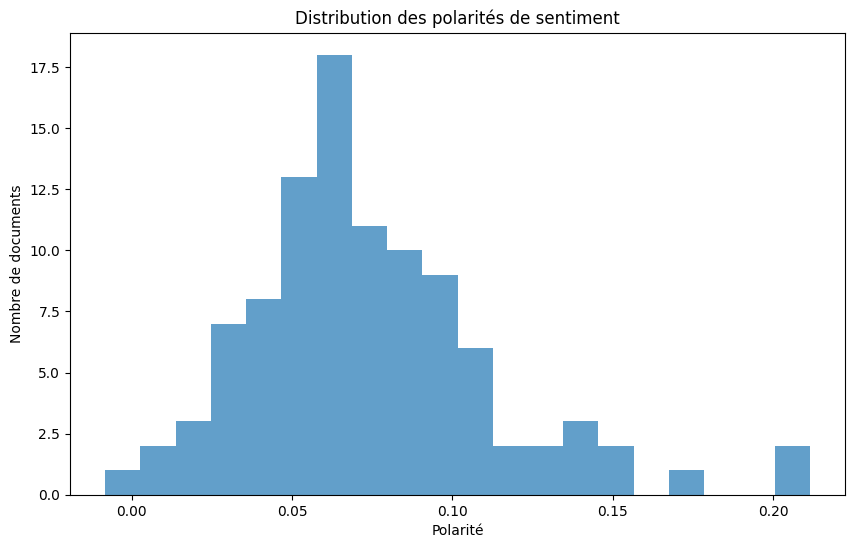

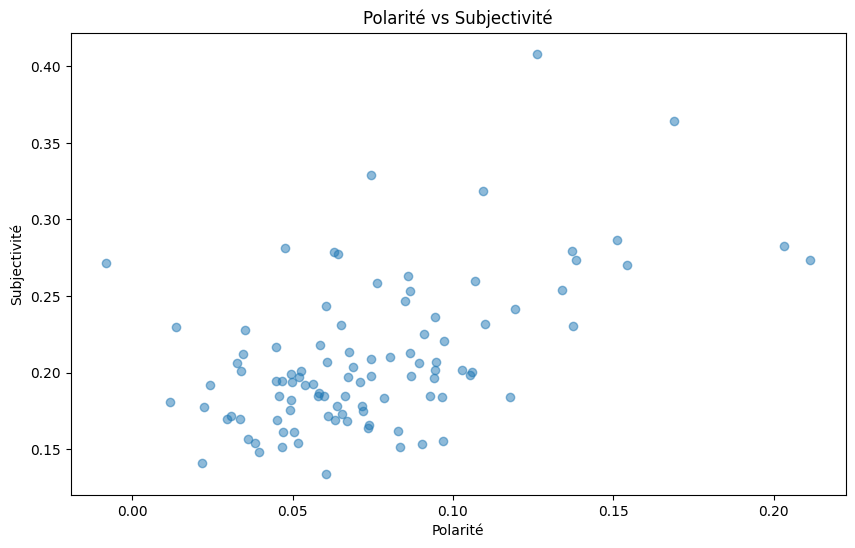

In [11]:
# Analyse de Sentiment

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

# Fonction pour analyser le sentiment
def analyze_sentiment(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    return blob.sentiment

# Analyser sentiment pour chaque document
sentiments = []
for text in cleaned_texts[:100]:  # Limiter pour performance
    sent = analyze_sentiment(text)
    sentiments.append(sent)

# Extraire polarité et subjectivité
polarities = [s[0] for s in sentiments]
subjectivities = [s[1] for s in sentiments]

print(f"Polarité moyenne : {sum(polarities)/len(polarities):.2f}")
print(f"Subjectivité moyenne : {sum(subjectivities)/len(subjectivities):.2f}")

# Distribution des polarités
plt.figure(figsize=(10, 6))
plt.hist(polarities, bins=20, alpha=0.7)
plt.title("Distribution des polarités de sentiment")
plt.xlabel("Polarité")
plt.ylabel("Nombre de documents")
plt.show()

# Scatter plot polarité vs subjectivité
plt.figure(figsize=(10, 6))
plt.scatter(polarities, subjectivities, alpha=0.5)
plt.title("Polarité vs Subjectivité")
plt.xlabel("Polarité")
plt.ylabel("Subjectivité")
plt.show()

## 7. Clustering

Regroupement des documents en clusters thématiques utilisant K-Means sur les vecteurs TF-IDF.

**Note narrative :** Le clustering révèle des groupes thématiques. Avantage : découverte de patterns cachés. Limite : nécessite choix du nombre de clusters (k) ; dans les corpus historiques, les clusters peuvent mélanger époques ou contextes si les termes évoluent (e.g., cluster "guerre" vs "paix" en 1939-1945).

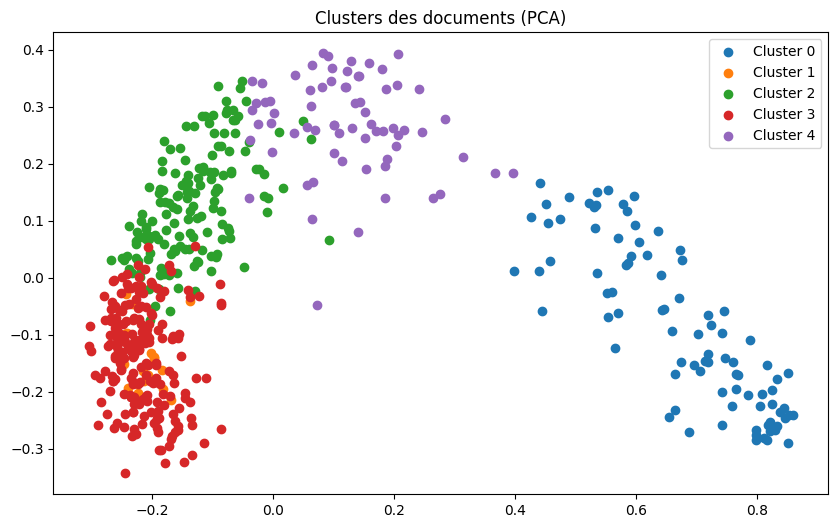

Cluster 0 termes clés : mod, bruxelles, maison, louer, tél, ecrire, ecr, dem, rossel, rue
Cluster 1 termes clés : cette, ministre, londres, quo, contre, langleterre, berlin, guerre, plus, novembre
Cluster 2 termes clés : dun, tout, dune, fait, ministre, quil, guerre, gouvernement, cette, plus
Cluster 3 termes clés : anglais, fait, deux, contre, gouvernement, allemands, cette, troupes, guerre, plus
Cluster 4 termes clés : ans, concert, deux, dimanche, match, cette, bruxelles, plus, rue, van


In [12]:
# Clustering

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Utiliser la matrice TF-IDF existante
num_clusters = 5  # Ajuster selon besoin
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Réduire dimension pour visualisation
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_matrix.toarray())

# Visualisation des clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    points = reduced_vectors[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
plt.title("Clusters des documents (PCA)")
plt.legend()
plt.show()

# Termes représentatifs par cluster
for i in range(num_clusters):
    cluster_docs = tfidf_matrix[clusters == i]
    if cluster_docs.shape[0] > 0:
        centroid = cluster_docs.mean(axis=0)
        top_terms_idx = centroid.argsort()[0, -10:][::-1]
        top_terms = [feature_names[idx] for idx in top_terms_idx.tolist()[0]]
        print(f"Cluster {i} termes clés : {', '.join(top_terms)}")

## 8. Word Embeddings (Word2Vec)

Entraînement d'un modèle Word2Vec pour analyser les similarités sémantiques entre termes liés à l'aviation et la communication.

**Note narrative :** Les embeddings capturent les relations sémantiques. Avantage : similarités fines (e.g., "pilote" proche de "aviateur"). Limite : nécessite beaucoup de données ; sur corpus limité historique, les embeddings peuvent être bruités par OCR et manquer de généralisation (e.g., "télégraphe" vs "satellite" non présents).

In [13]:
# Word Embeddings (Word2Vec)

from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec
model = Word2Vec(sentences=processed_texts, vector_size=100, window=5, min_count=2, workers=4)

# Sauvegarder le modèle
model.save("word2vec_aviation_communication.model")

# Tester similarités
test_words = ['aviation', 'communication', 'pilote', 'radio', 'vol']
for word in test_words:
    if word in model.wv:
        similar = model.wv.most_similar(word, topn=5)
        print(f"Termes similaires à '{word}' : {similar}")
    else:
        print(f"'{word}' pas dans le vocabulaire")

# Visualisation avec t-SNE (optionnel, si installé)
# from sklearn.manifold import TSNE
# words = list(model.wv.index_to_key)[:100]
# vectors = model.wv[words]
# tsne = TSNE(n_components=2, random_state=42)
# reduced = tsne.fit_transform(vectors)
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced[:, 0], reduced[:, 1])
# for i, word in enumerate(words):
#     plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
# plt.title("Word2Vec Embeddings (t-SNE)")
# plt.show()

Termes similaires à 'aviation' : [('lartillerie', 0.8662388324737549), ('ennemie', 0.8605550527572632), ('blindée', 0.8501484990119934), ('larme', 0.838021993637085), ('exécuté', 0.8351501822471619)]
Termes similaires à 'communication' : [('mlso', 0.8407197594642639), ('relierait', 0.8363091349601746), ('tentative', 0.8267815709114075), ('démarche', 0.8249363303184509), ('nouveue', 0.8246166706085205)]
Termes similaires à 'pilote' : [('équipage', 0.9626501798629761), ('submersible', 0.9623483419418335), ('sousmarln', 0.9587274193763733), ('lavion', 0.9555745124816895), ('tombé', 0.9505277276039124)]
Termes similaires à 'radio' : [('dépêche', 0.9267949461936951), ('mande', 0.9224076271057129), ('annonce', 0.919425368309021), ('press', 0.912155270576477), ('datée', 0.9066698551177979)]
Termes similaires à 'vol' : [('davion', 0.9221475720405579), ('piqué', 0.9194521903991699), ('appareil', 0.9112284183502197), ('fumée', 0.9109709858894348), ('endommagée', 0.9087319374084473)]


## 9. Modélisation de Thèmes (LDA)

Modélisation de thèmes latents pour découvrir des sujets sous-jacents dans le corpus.

**Note narrative :** LDA révèle des thèmes cachés. Avantage : complément au clustering pour interprétation. Limite : sujets peuvent être abstraits ; dans les textes historiques, les thèmes peuvent être influencés par l'époque (e.g., thème "guerre aérienne" dominant en 1939-1940).

In [14]:
# Modélisation de Thèmes (LDA)

from sklearn.decomposition import LatentDirichletAllocation

# LDA sur la matrice TF-IDF
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

# Afficher les thèmes
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Thème {topic_idx}: {', '.join(top_words)}")

# Distribution des thèmes par document (premier document exemple)
print(f"\nDistribution des thèmes pour le premier document : {lda_topics[0]}")

Thème 0: ach, bain, env, louer, enf, etude, gar, app, pet, terr
Thème 1: ach, bain, env, louer, enf, etude, gar, app, pet, terr
Thème 2: ach, bain, env, louer, enf, etude, gar, app, pet, terr
Thème 3: rue, dem, rossel, tél, ecr, ecrire, louer, bruxelles, maison, mod
Thème 4: plus, cette, guerre, gouvernement, dune, fait, deux, contre, quil, dun

Distribution des thèmes pour le premier document : [0.01078706 0.01078706 0.01078706 0.0109886  0.95665022]


## 10. Conclusion et Notes Narratives

Cette étude transversale a appliqué diverses techniques NLP au sous-corpus txt_aviation pour explorer le thème "aviation AND communication". Les analyses ont révélé des intersections clés, comme les termes fréquents "aviation", "communication", et des entités liées aux pilotes et organisations.

**Avantages du traitement automatique :**
- Rapidité et scalabilité pour analyser de gros volumes de texte historique.
- Quantification objective des fréquences, sentiments, et clusters.
- Découverte de patterns (e.g., similarités sémantiques via Word2Vec).

**Limites dans un contexte historique :**
- Erreurs OCR introduisent du bruit, affectant la tokenisation et les embeddings.
- Modèles entraînés sur données modernes peuvent mal généraliser aux langues formelles ou obsolètes de 1939-1945.
- Manque de contexte temporel : les termes évoluent (e.g., "radio" en 1939 vs aujourd'hui).
- Biais du corpus : journaux spécifiques peuvent surreprésenter certains aspects.

**Recommandations :** Combiner avec expertise historique pour interprétation ; améliorer le prétraitement pour OCR ; utiliser modèles spécialisés en diachronie linguistique. Cette approche démontre le potentiel de NLP pour l'histoire, mais souligne la nécessité d'adaptation aux spécificités des textes anciens.